This set of tutorials aim to introduce the important ephys and histology tables that are ready for usage. We will mention some basics of DataJoint but not systematically. For a full-fledged tutorial on the basics, please visit:  

>* [Get DataJoint Ready](../201909_code_camp/0-Get%20DataJoint%20Ready.ipynb): connection to database, set up config
>* [Explore IBL data pipeline with DataJoint](../201909_code_camp/1-Explore%20IBL%20data%20pipeline%20with%20DataJoint.ipynb): plot diagram, query, and fetch
>* [Analyze data with IBL pipeline and save results](../201909_code_camp/2-Analyze%20data%20with%20IBL%20pipeline%20and%20save%20results.ipynb): use imported and computed table to autopopulate results

# Connect to IBL datajoint database

In [1]:
import datajoint as dj
from getpass import getpass

# set up dj.config
dj.config['database.host'] = 'datajoint.internationalbrainlab.org'
dj.config['database.user'] = '{YOUR_USER_NAME}'
dj.config['database.password'] = getpass('Please type in your password: ')

# connect to the database
dj.conn()

# save the config locally
dj.config.save_local()

Please type in your password:  ······


Connecting shan@datajoint.internationalbrainlab.org:3306


# List all the schemas you have access to, using `dj.list_schemas()`

In [2]:
dj.list_schemas()

['group_shared_anneurai_analyses',
 'group_shared_anneurai_psytrack',
 'group_shared_end_criteria',
 'group_shared_ephys',
 'group_shared_sfndata',
 'group_shared_testing',
 'group_shared_wheel',
 'group_shared_wheel_moves',
 'ibl_acquisition',
 'ibl_action',
 'ibl_alyxraw',
 'ibl_analyses_behavior',
 'ibl_analyses_ephys',
 'ibl_behavior',
 'ibl_data',
 'ibl_dj_acquisition',
 'ibl_dj_action',
 'ibl_dj_behavior',
 'ibl_dj_data',
 'ibl_dj_reference',
 'ibl_dj_subject',
 'ibl_ephys',
 'ibl_histology',
 'ibl_ingest_acquisition',
 'ibl_ingest_action',
 'ibl_ingest_data',
 'ibl_ingest_ephys',
 'ibl_ingest_histology',
 'ibl_ingest_reference',
 'ibl_ingest_subject',
 'ibl_jaib1_tutorial',
 'ibl_patch',
 'ibl_plotting_behavior',
 'ibl_plotting_ephys',
 'ibl_public',
 'ibl_reference',
 'ibl_storage',
 'ibl_subject',
 'ibl_update',
 'test_group_shared_ephys',
 'test_group_shared_wheel',
 'test_ibl_acquisition',
 'test_ibl_action',
 'test_ibl_alyxraw',
 'test_ibl_analyses_behavior',
 'test_ibl_ana

## Major schemas:   
Meta data from **Alyx**: `ibl_reference`, `ibl_subject`, `ibl_action`, `ibl_acquisition`, and `ibl_data`  
Imported data from **FlatIron**: `ibl_behavior`, `ibl_ephys`, `ibl_histology`  
Computed analzyed results: `ibl_analyses_behavior`, `ibl_analyses_ephys` 

# Access the schemas

There are two ways of accessing the schemas with DataJoint

>* Create virtual modules
>* Import modules from ibl-pipeline

## Create virtual modules 
The tables are designed and generated with DataJoint and the codes are in ibl-pipeline, however, if you just want to access the table contents, you don't have to get the code that defines the tables. Instead, DataJoint provides an method called `create_virtual_module`, allowing users to reconstruct the modules and classes based on the **current** structure of the tables in the database. For example:

In [2]:
ephys = dj.create_virtual_module('ephys', 'ibl_ephys')

The first argument is the `__name__` of the module you would like to give, usually not very important. The second argument is the schema name.

Now we get the virtual module `ephys`, that contains all the classes to interact with the tables in the schema. Apart from the populate methods, you could do all other DJ operations on this virtual module, including diagram, queries, fetches, create child tables, delete, and drop. Please be extra coutious in deleting and dropping tables.

Let's take a look at the relational diagram of the module:

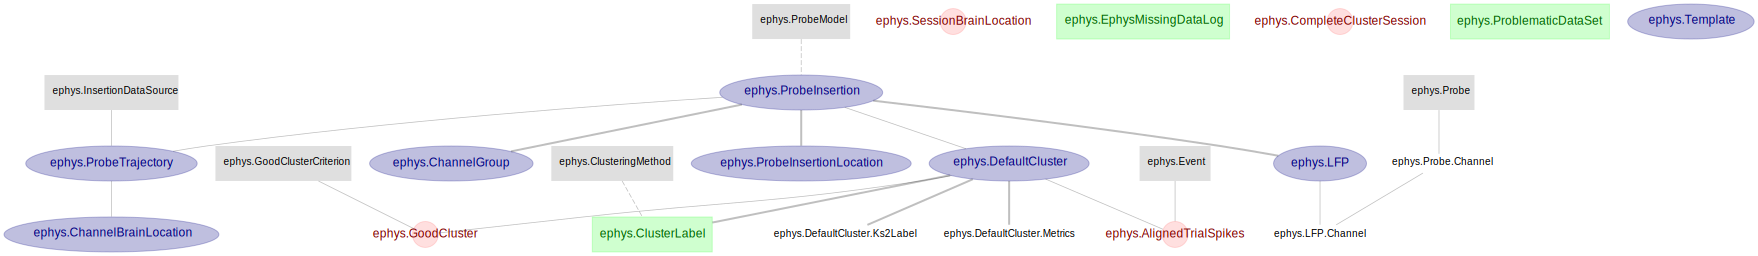

In [3]:
dj.Diagram(ephys)

Here is a friendly reminder of what these shapes, colors and lines mean:

**Table tiers**:  
Manual table: green box  
Lookup table: gray box  
Imported table: blue oval  
Computed table: red circle  
Part table: plain text

Meaning of table tiers could be found in this [presentation](https://docs.google.com/presentation/d/1mp3Bro1_o_nPScD_g0ygw2z633Rdnd-GGlFEJZmhrBs/edit#slide=id.g7e7b39a7dc_0_5)

**Dependencies**:  
One-to-one primary: thick solid line  
One-to-many primary: thin solid line  
Secondary foreign key reference: dashed line  
Renamed secondary foreign key references: orange dot

We could access tables with the classes of the virtual module. 

In [7]:
ephys.DefaultCluster().describe();

-> ephys.ProbeInsertion
cluster_id           : int                          
---
cluster_uuid         : uuid                         # uuid of this cluster
cluster_channel      : int                          # which channel this cluster is from
cluster_amp=null     : float                        # Mean amplitude of each cluster (µV)
cluster_waveforms=null : blob@ephys                   # Waveform from spike sorting templates (stored as a sparse array, only for a subset of channels closest to the peak channel)
cluster_waveforms_channels=null : blob@ephys                   # Index of channels that are stored for each cluster waveform. Sorted by increasing distance from the maximum amplitude channel.
cluster_depth=null   : float                        # Depth of mean cluster waveform on probe (µm). 0 means deepest site, positive means above this.
cluster_peak_to_trough=null : blob@ephys                   # trough to peak time (ms)
cluster_spikes_times : blob@ephys                   # spik

Create virtual modules are particularly useful in the following scenarios:

>* `group_shared_` schemas: these are the schemas created by the users, and the code to create these modules are not necessarily accessible easily.
>* `ibl_` schemas: these schemas were created and defined in ibl-pipeline, but as we are in rapid development, the lastest ibl-pipeline package we released may not reflect the current status of the tables. Create virtual modules is a very good way to access the tables with their current definitions.

For ephys tables, there are a lot of external fields, such as the `blob@ephys` shown in the above definition. External storage is a feature provided by DataJoint that allows saving bulky data into s3 buckets. From the user point of view, there is no difference from a internal field. However, using external fields need to pre-configure the storage location. Without the configuration, datajoint does not know where to fetch the data.

In [8]:
# fetch the first two entries
ephys.DefaultCluster.fetch('cluster_spikes_times', limit=2)

DataJointError: Storage ephys is requested but not configured

To fix the problem, we could `import ibl_pipeline`, where the external storage location was configured. The configuration is stable across different versions of ibl_pipeline.

In [9]:
import ibl_pipeline
ephys.DefaultCluster.fetch('cluster_spikes_times', limit=2)

array([array([  25.1692025 ,   37.50014487,   58.69313116,   78.7905284 ,
         80.71924227,  144.25720038,  213.86406207,  261.48474526,
        262.60270056,  264.72261234,  265.7261688 ,  268.45250775,
        353.55927449,  431.50371236,  443.48652333,  452.3770992 ,
        525.79811614,  526.12714611,  564.57628711,  594.35971676,
        682.01772449,  682.95391498,  693.92893678,  697.69693182,
        706.3061777 ,  737.06083212,  751.12258945,  773.45349632,
        835.30670295,  862.90599017,  863.25172001,  878.7815628 ,
        887.10911185,  909.77874908,  981.84345312, 1007.67615832,
       1015.56701178, 1016.55666843, 1053.46949474, 1056.36786539,
       1091.13251337, 1132.98872281, 1135.78529449, 1143.82147977,
       1147.19964555, 1206.16998165, 1248.79941668, 1259.92800402,
       1272.51634327, 1286.45260224, 1290.63115995, 1299.89383289,
       1341.31214731, 1363.59235541, 1375.89153112, 1384.01131574,
       1393.26348894, 1414.36420917, 1451.32086947, 150

## Directly import from ibl-pipeline

A more routined method is to directly import modules from the package `ibl-pipeline`

In [10]:
from ibl_pipeline import ephys, histology

Connected to https://alyx.internationalbrainlab.org as vathes
Connected to https://alyx.internationalbrainlab.org as vathes


In [12]:
ephys.DefaultCluster()

subject_uuid,session_start_time start time,"probe_idx probe insertion number (0 corresponds to probe00, 1 corresponds to probe01)",cluster_id,cluster_uuid uuid of this cluster,cluster_channel which channel this cluster is from,cluster_amp Mean amplitude of each cluster (µV),"cluster_waveforms Waveform from spike sorting templates (stored as a sparse array, only for a subset of channels closest to the peak channel)",cluster_waveforms_channels Index of channels that are stored for each cluster waveform. Sorted by increasing distance from the maximum amplitude channel.,"cluster_depth Depth of mean cluster waveform on probe (µm). 0 means deepest site, positive means above this.",cluster_peak_to_trough trough to peak time (ms),cluster_spikes_times spike times of a particular cluster (seconds),"cluster_spikes_depths Depth along probe of each spike (µm; computed from waveform center of mass). 0 means deepest site, positive means above this",cluster_spikes_amps Amplitude of each spike (µV),cluster_spikes_templates Template ID of each spike (i.e. output of automatic spike sorting prior to manual curation),"cluster_spikes_samples Time of spikes, measured in units of samples in their own electrophysiology binary file.",cluster_ts
088b6898-0a86-435e-b91f-eab829a846f6,2019-11-21 17:11:10,0,0,282f9b1b-76a6-490a-8d94-b775cdd0233e,0,6.67352e-05,=BLOB=,=BLOB=,20.0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2020-02-29 08:34:07
088b6898-0a86-435e-b91f-eab829a846f6,2019-11-21 17:11:10,0,1,f188cde0-7f1f-4167-8be2-d3faa7fbbd91,24,3.48077e-05,=BLOB=,=BLOB=,260.0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2020-02-29 08:34:07
088b6898-0a86-435e-b91f-eab829a846f6,2019-11-21 17:11:10,0,2,7ebf839f-9a25-4bb6-a779-dd5ee54d9251,2,3.36056e-05,=BLOB=,=BLOB=,40.0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2020-02-29 08:34:08
088b6898-0a86-435e-b91f-eab829a846f6,2019-11-21 17:11:10,0,3,0c4253e0-b686-4aee-ab6a-a5d1d580797d,16,4.11273e-05,=BLOB=,=BLOB=,180.0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2020-02-29 08:34:09
088b6898-0a86-435e-b91f-eab829a846f6,2019-11-21 17:11:10,0,4,0499d269-474e-458b-9960-fea076b43f21,26,3.31644e-05,=BLOB=,=BLOB=,280.0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2020-02-29 08:34:09
088b6898-0a86-435e-b91f-eab829a846f6,2019-11-21 17:11:10,0,5,fd75a346-609d-47dc-bdaf-31cbff6fb06a,23,nan,=BLOB=,=BLOB=,240.0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2020-02-29 08:34:09
088b6898-0a86-435e-b91f-eab829a846f6,2019-11-21 17:11:10,0,6,7e907032-aa17-48a3-9312-a096f29ff7fe,20,3.18816e-05,=BLOB=,=BLOB=,220.0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2020-02-29 08:34:10
088b6898-0a86-435e-b91f-eab829a846f6,2019-11-21 17:11:10,0,7,f214509e-4658-4456-a543-dc0952165857,22,7.18595e-05,=BLOB=,=BLOB=,240.0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2020-02-29 08:34:10
088b6898-0a86-435e-b91f-eab829a846f6,2019-11-21 17:11:10,0,8,793ae42f-0a97-4c1d-8eff-d5bf8bde940a,24,7.26341e-05,=BLOB=,=BLOB=,260.0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2020-02-29 08:34:11
088b6898-0a86-435e-b91f-eab829a846f6,2019-11-21 17:11:10,0,9,9cc6d6b3-e8c3-49e8-8f81-e57fb485fe11,24,3.40825e-05,=BLOB=,=BLOB=,260.0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2020-02-29 08:34:12


In [15]:
histology.ClusterBrainRegion() & 'insertion_data_source like "%Ephys%"'

subject_uuid,session_start_time start time,"probe_idx probe insertion number (0 corresponds to probe00, 1 corresponds to probe01)",cluster_id,insertion_data_source type of trajectory,ontology,acronym
b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-27 16:52:31,0,241,Ephys aligned histology track,CCF 2017,ACAd6a
b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-27 16:52:31,0,242,Ephys aligned histology track,CCF 2017,ACAd6a
b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-27 16:52:31,0,243,Ephys aligned histology track,CCF 2017,ACAd6a
b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-27 16:52:31,0,244,Ephys aligned histology track,CCF 2017,ACAd6a
b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-27 16:52:31,0,245,Ephys aligned histology track,CCF 2017,ACAd6a
b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-27 16:52:31,0,246,Ephys aligned histology track,CCF 2017,ACAd6a
b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-27 16:52:31,0,247,Ephys aligned histology track,CCF 2017,ACAd6a
b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-27 16:52:31,0,248,Ephys aligned histology track,CCF 2017,ACAd6a
b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-27 16:52:31,0,249,Ephys aligned histology track,CCF 2017,ACAd6a
b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-27 16:52:31,0,250,Ephys aligned histology track,CCF 2017,ACAd6a


# Summary

In this notebook, we introduced the approaches to connect to the database, access schemas and tables. We especially illustrated the usage of `dj.create_virtual_module`, which is quite useful when accessing the rapidly changing schemas and tables.

In the [next notebook](01-Introduction%20of%20ephys%20and%20histology%20tables.ipynb), we will go through the important tables in ephys and histology schemas one-by-one.